In [39]:
# Import standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings

# Configure visualizations
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')  # Updated style name for newer matplotlib
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.size'] = 12

# Suppress warnings
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)


In [40]:
# 1. Load Dataset
nyc_df = pd.read_csv('dataset1/AB_NYC_2019.csv')

# Get a quick overview of the data
print(f"Dataset shape: {nyc_df.shape}")
nyc_df.head()


Dataset shape: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [41]:
# 2. Initial Data Exploration
print("Data Types:")
print(nyc_df.dtypes)

print("\nMissing Values:")
# Reset option to ensure we see all rows
pd.reset_option('display.max_rows')
missing_values = nyc_df.isnull().sum()
print(missing_values[missing_values > 0])

# Calculate percentage of missing values
missing_percentage = (missing_values / len(nyc_df)) * 100
print("\nPercentage of missing values:")
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))


Data Types:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Missing Values:
name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64

Percentage of missing values:
reviews_per_month    20.558339
last_review          20.558339
host_name             0.042949
name                  0.032723
dtype: fl

In [42]:
# 3. Handle Missing Values
nyc_clean = nyc_df.copy()

# For name, replace with 'Unnamed Listing'
nyc_clean['name'].fillna('Unnamed Listing', inplace=True)

# For host_name, replace with 'Unknown Host'
nyc_clean['host_name'].fillna('Unknown Host', inplace=True)

# For reviews_per_month, fill with 0 (no reviews)
nyc_clean['reviews_per_month'].fillna(0, inplace=True)

# For last_review, mark as 'No Reviews' where appropriate
no_reviews_mask = nyc_clean['number_of_reviews'] == 0
nyc_clean.loc[no_reviews_mask, 'last_review'] = 'No Reviews'

# Check remaining missing values
print("Remaining missing values:")
print(nyc_clean.isnull().sum()[nyc_clean.isnull().sum() > 0])


Remaining missing values:
Series([], dtype: int64)


In [43]:
# 4. Remove Duplicates
# Check for duplicate rows
duplicate_rows = nyc_clean.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

# Check for potential duplicates based on key attributes
potential_duplicates = nyc_clean.duplicated(subset=['host_id', 'room_type', 'neighbourhood', 'price'], keep=False)
print(f"Number of potential duplicate listings: {potential_duplicates.sum()}")

# Remove exact duplicates
nyc_clean = nyc_clean.drop_duplicates()


Number of duplicate rows: 0
Number of potential duplicate listings: 5230


In [44]:
# 5. Standardize Data
# Standardize text fields
text_columns = ['name', 'host_name', 'neighbourhood', 'neighbourhood_group']
for col in text_columns:
    nyc_clean[col] = nyc_clean[col].str.strip().str.lower()

# Standardize room_type values
print("Unique room types before standardization:", nyc_clean['room_type'].unique())

# Create mapping dictionary
room_type_map = {
    'private room': 'private_room',
    'entire home/apt': 'entire_home',
    'shared room': 'shared_room'
}

# Apply the mapping
nyc_clean['room_type'] = nyc_clean['room_type'].str.lower().map(room_type_map).fillna(nyc_clean['room_type'])
print("Unique room types after standardization:", nyc_clean['room_type'].unique())


Unique room types before standardization: ['Private room' 'Entire home/apt' 'Shared room']
Unique room types after standardization: ['private_room' 'entire_home' 'shared_room']


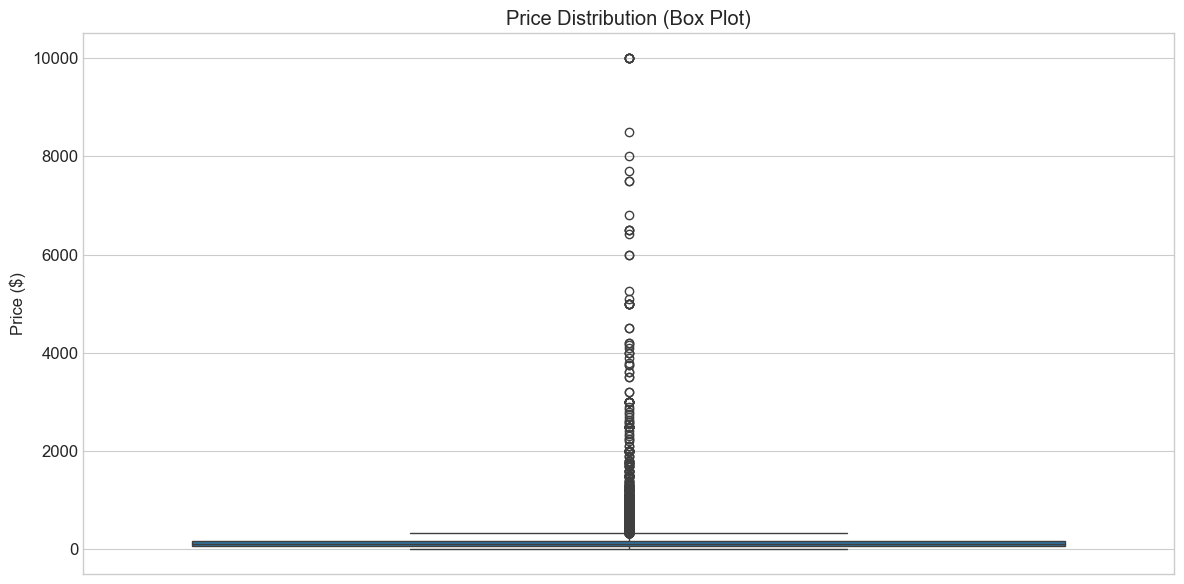

Price outlier bounds: Lower = $-90.00, Upper = $334.00
Number of price outliers: 2972


In [45]:
# 6. Process Date Fields and Handle Outliers

# Identify rows without reviews
no_reviews_mask = nyc_clean['last_review'] == 'No Reviews'
# Convert valid dates to datetime format
date_rows = ~no_reviews_mask  # Rows that have review dates
nyc_clean.loc[date_rows, 'last_review'] = pd.to_datetime(nyc_clean.loc[date_rows, 'last_review'])

# Outlier Detection for prices
plt.figure(figsize=(12, 6))
sns.boxplot(y=nyc_clean['price'])
plt.title('Price Distribution (Box Plot)')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

# Calculate IQR for price
Q1 = nyc_clean['price'].quantile(0.25)
Q3 = nyc_clean['price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Price outlier bounds: Lower = ${lower_bound:.2f}, Upper = ${upper_bound:.2f}")
print(f"Number of price outliers: {((nyc_clean['price'] < lower_bound) | (nyc_clean['price'] > upper_bound)).sum()}")

# Cap extreme values
nyc_clean_no_outliers = nyc_clean.copy()
nyc_clean_no_outliers['price'] = nyc_clean_no_outliers['price'].clip(lower=max(0, lower_bound), upper=upper_bound)


Room type distribution after cleaning:
room_type
entire_home     25409
private_room    22326
shared_room      1160
Name: count, dtype: int64


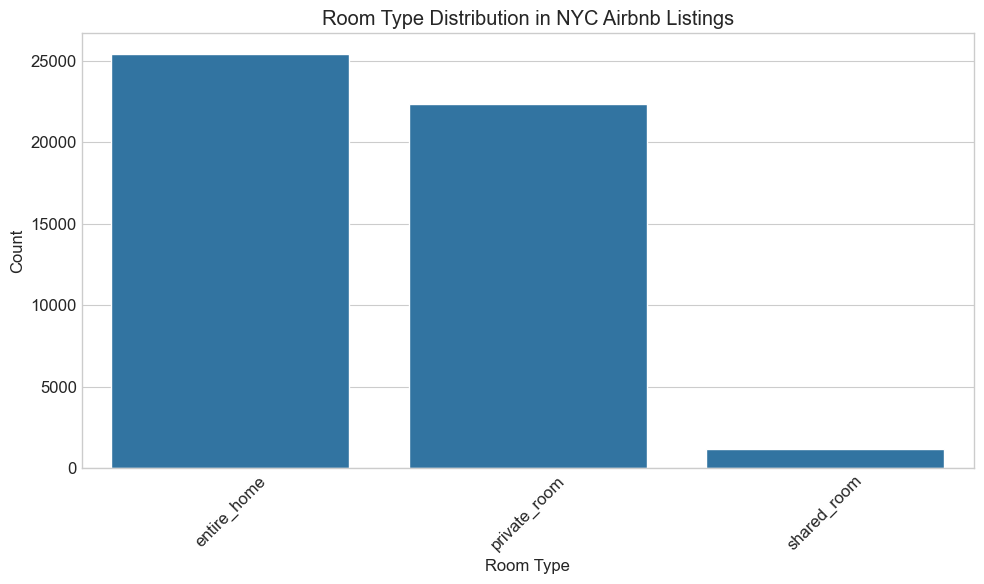


Average price by neighborhood and room type:
room_type            entire_home  private_room  shared_room
neighbourhood_group                                        
bronx                 121.559367     62.273006    52.033333
brooklyn              160.194686     72.105409    49.421308
manhattan             203.671566    105.004134    84.004167
queens                138.483779     67.403025    52.787879
staten island         130.767045     62.292553    57.444444


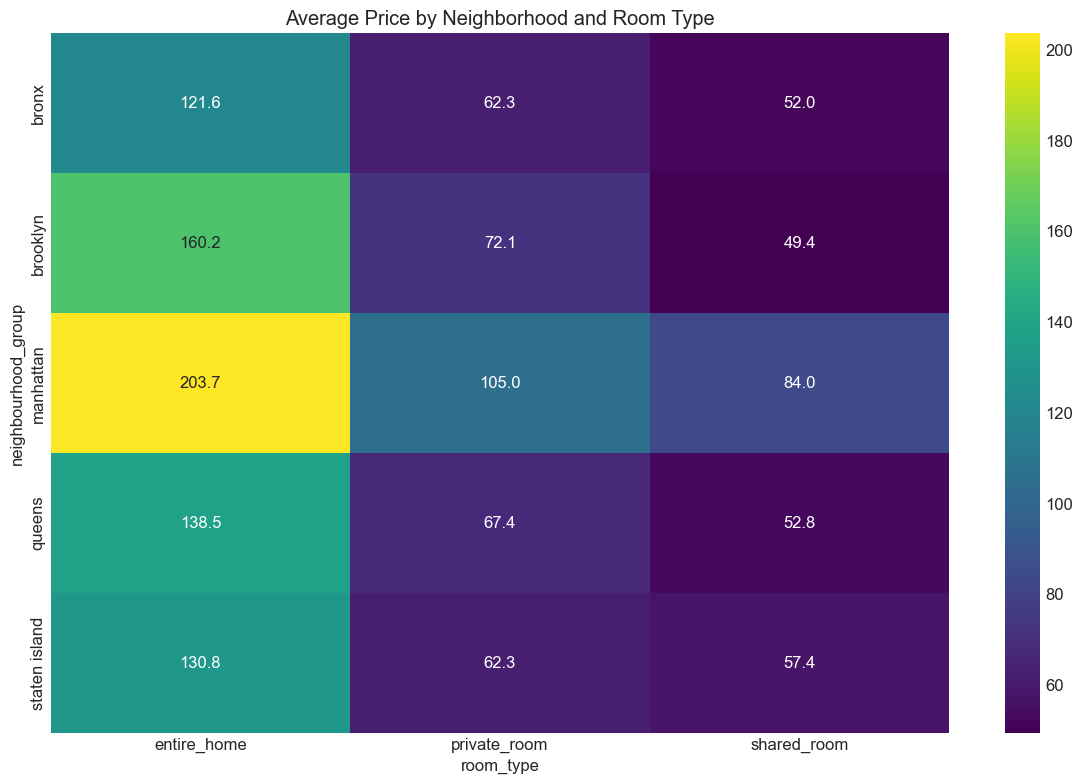

In [46]:
# 7. Analyze Cleaned NYC Data

# Room type distribution
room_types = nyc_clean_no_outliers['room_type'].value_counts()
print("Room type distribution after cleaning:")
print(room_types)

# Visualize room type distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=room_types.index, y=room_types.values)
plt.title('Room Type Distribution in NYC Airbnb Listings')
plt.ylabel('Count')
plt.xlabel('Room Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Average price by neighborhood group and room type
avg_price_by_area = nyc_clean_no_outliers.groupby(['neighbourhood_group', 'room_type'])['price'].mean().unstack()
print("\nAverage price by neighborhood and room type:")
print(avg_price_by_area)

# Visualize prices by neighborhood
plt.figure(figsize=(12, 8))
sns.heatmap(avg_price_by_area, annot=True, fmt='.1f', cmap='viridis')
plt.title('Average Price by Neighborhood and Room Type')
plt.tight_layout()
plt.show()


In [47]:
# 1. Load Dataset
youtube_df = pd.read_csv('dataset2/USvideos.csv')

print(f"Dataset shape: {youtube_df.shape}")
youtube_df.head(3)


Dataset shape: (40949, 16)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...


In [48]:
# 2. Initial Data Exploration
print("Data Types:")
print(youtube_df.dtypes)

print("\nMissing Values:")
pd.reset_option('display.max_rows')
missing_values = youtube_df.isnull().sum()
print(missing_values[missing_values > 0])

# Load category information from JSON file
with open('dataset2/US_category_id.json', 'r') as f:
    categories_data = json.load(f)
    
# Create a dictionary mapping category IDs to their names
category_map = {}
for item in categories_data['items']:
    category_map[item['id']] = item['snippet']['title']
    
# Add a category_name column to the dataset
youtube_df['category_name'] = youtube_df['category_id'].astype(str).map(category_map)


Data Types:
video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
dtype: object

Missing Values:
description    570
dtype: int64


In [49]:
# 3. Data Cleaning Process for YouTube Data

# Create a clean copy
youtube_clean = youtube_df.copy()

# Handle missing values
youtube_clean['description'].fillna('', inplace=True)
youtube_clean['tags'].fillna('', inplace=True)
youtube_clean['category_name'].fillna('Unknown', inplace=True)

# Remove duplicates - keep the latest version of each video
youtube_clean = youtube_clean.sort_values('trending_date', ascending=False).drop_duplicates(subset=['video_id'], keep='first')
print(f"Shape after removing duplicates: {youtube_clean.shape}")

# Convert publish_time to datetime
youtube_clean['publish_time'] = pd.to_datetime(youtube_clean['publish_time'])

# Handle trending_date - use original format to avoid conversion errors
youtube_clean['trending_date_original'] = youtube_clean['trending_date'].copy()

# Standardize text columns
youtube_clean['title'] = youtube_clean['title'].str.strip()
youtube_clean['channel_title'] = youtube_clean['channel_title'].str.strip()

# Convert boolean columns
bool_cols = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']
for col in bool_cols:
    youtube_clean[col] = youtube_clean[col].astype(bool)


Shape after removing duplicates: (6351, 17)


In [50]:
# 4. Feature Engineering for Engagement Metrics

# Calculate engagement ratio (likes + dislikes) / views
# Handle division by zero
youtube_clean['engagement_ratio'] = 0.0  # Default value
mask = youtube_clean['views'] > 0  # Filter for non-zero views
youtube_clean.loc[mask, 'engagement_ratio'] = (youtube_clean.loc[mask, 'likes'] + 
                                             youtube_clean.loc[mask, 'dislikes']) / youtube_clean.loc[mask, 'views']

# Calculate like ratio - likes / (likes + dislikes)
youtube_clean['like_ratio'] = 0.0  # Default value
mask = (youtube_clean['likes'] + youtube_clean['dislikes']) > 0  # Filter for videos with ratings
youtube_clean.loc[mask, 'like_ratio'] = youtube_clean.loc[mask, 'likes'] / (youtube_clean.loc[mask, 'likes'] + 
                                                                          youtube_clean.loc[mask, 'dislikes'])

# Check the results
print("Sample with new engagement features:")
youtube_clean[['video_id', 'views', 'likes', 'dislikes', 'engagement_ratio', 'like_ratio']].head(3)


Sample with new engagement features:


,video_id,views,likes,dislikes,engagement_ratio,like_ratio
37951,xTlNMmZKwpA,20723565,1018785,48090,0.051481,0.954924
38087,TjXQzRWmb_I,4579845,54636,1704,0.012302,0.969755
38077,1PhPYr_9zRY,6918222,611356,3653,0.088897,0.994060


views: 693 outliers identified
likes: 807 outliers identified
dislikes: 761 outliers identified
comment_count: 777 outliers identified


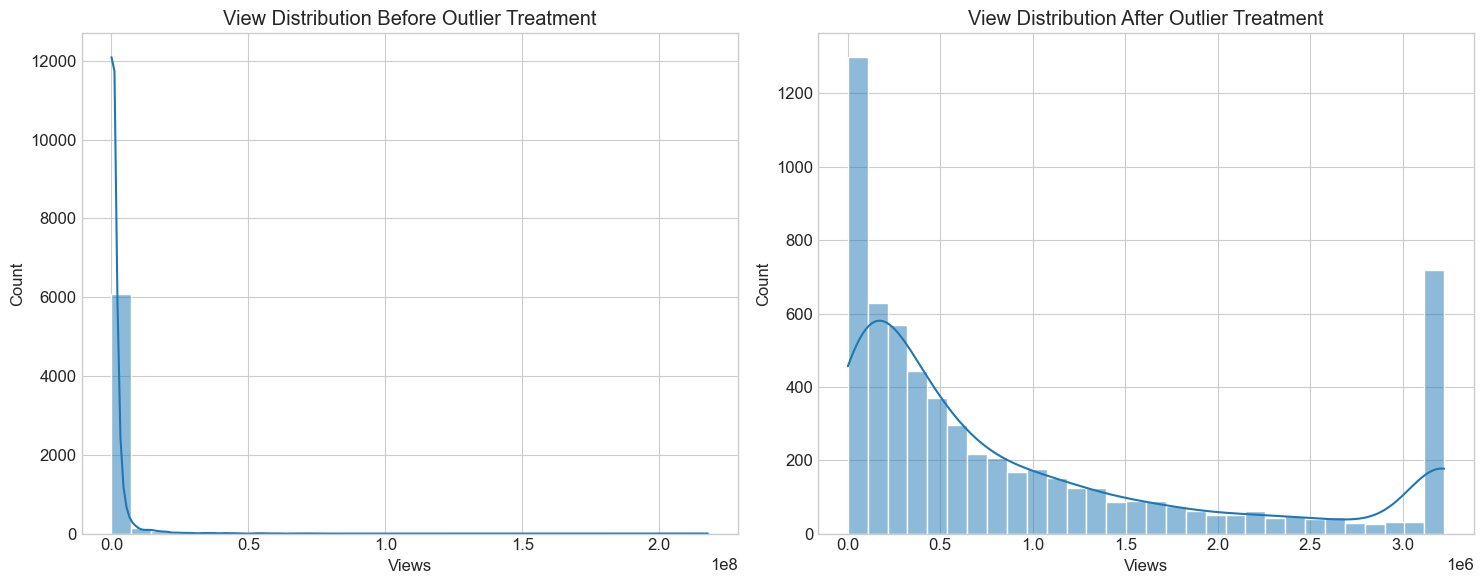

In [51]:
# 5. Outlier Detection in YouTube Data

# Define numeric columns to handle outliers
numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']

# Function to identify and cap outliers using IQR method
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    print(f"{column}: {outliers} outliers identified")
    
    # Cap the outliers to keep all data
    df[column] = df[column].clip(lower=max(0, lower_bound), upper=upper_bound)
    return df

# Apply outlier handling to all numeric columns
youtube_clean_no_outliers = youtube_clean.copy()
for col in numeric_cols:
    youtube_clean_no_outliers = handle_outliers(youtube_clean_no_outliers, col)

# Visualize one of the metrics before and after
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(youtube_clean['views'], kde=True, bins=30)
plt.title('View Distribution Before Outlier Treatment')
plt.xlabel('Views')

plt.subplot(1, 2, 2)
sns.histplot(youtube_clean_no_outliers['views'], kde=True, bins=30)
plt.title('View Distribution After Outlier Treatment')
plt.xlabel('Views')

plt.tight_layout()
plt.show()


Top 15 Most Common Tags:
              Tag  Count
0         "funny"    743
1        "comedy"    654
2         "humor"    282
3          [none]    258
4         "music"    249
5     "interview"    239
6      "comedian"    232
7    "television"    231
8     "celebrity"    230
9   "celebrities"    214
10    "talk show"    214
11         "news"    211
12      "trailer"    209
13       "how to"    205
14         "2018"    197


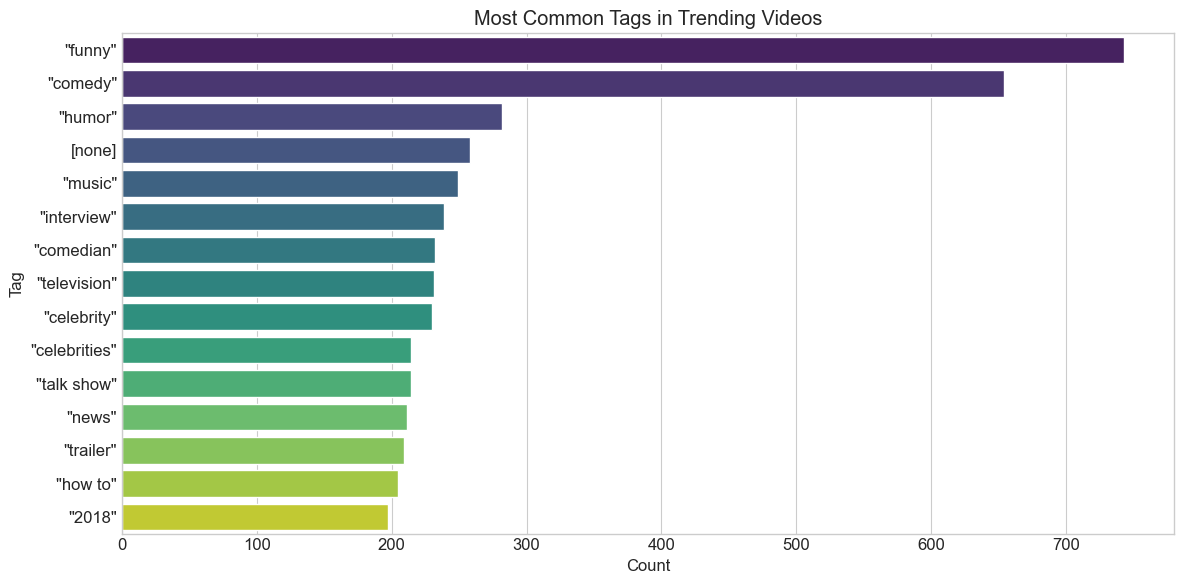

In [52]:
# 6. Tag Analysis with Error Handling

from collections import Counter

# Process tags (strings with '|' separator) with proper error handling
tags_list = youtube_clean_no_outliers['tags'].fillna('')
all_tags = []

# Process each tag string safely
for tag_str in tags_list:
    if isinstance(tag_str, str) and tag_str:
        try:
            # Split by the delimiter and clean each tag
            cleaned_tags = [tag.strip().lower() for tag in tag_str.split('|') if tag.strip()]
            all_tags.extend(cleaned_tags)
        except Exception as e:
            # Just in case there's an error with particular tags
            print(f"Error processing tag: {e}")
            continue

# Find most common tags
tag_counts = Counter(all_tags)
top_tags = pd.DataFrame(tag_counts.most_common(15), columns=['Tag', 'Count'])
print("Top 15 Most Common Tags:")
print(top_tags)

# Visualize tag distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Tag', data=top_tags, palette='viridis')
plt.title('Most Common Tags in Trending Videos')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()


Top Categories by Average Views:
                             views  count
category_name                            
Gaming                1.494664e+06    103
Music                 1.487663e+06    801
Film & Animation      1.265342e+06    320
Comedy                1.139527e+06    544
Entertainment         1.002616e+06   1621
People & Blogs        9.100757e+05    496
Science & Technology  7.895441e+05    381
Sports                7.813157e+05    449
Shows                 7.520608e+05      4
Autos & Vehicles      7.480136e+05     71


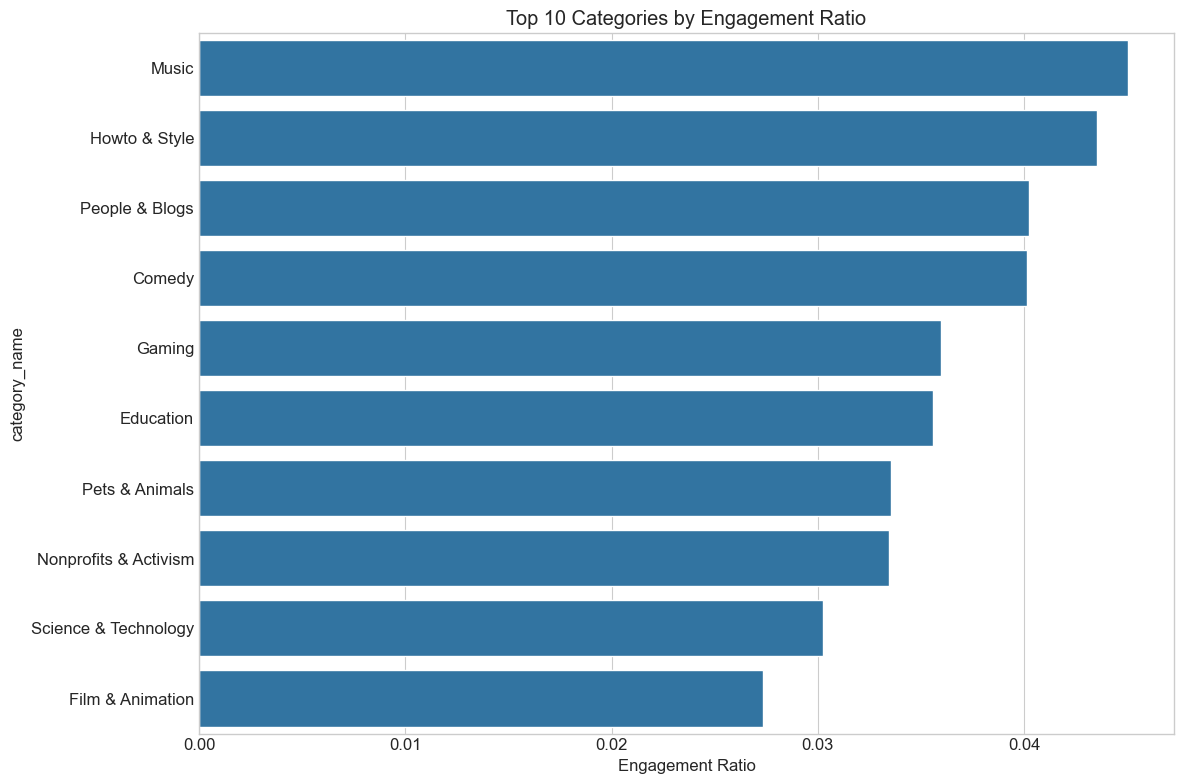

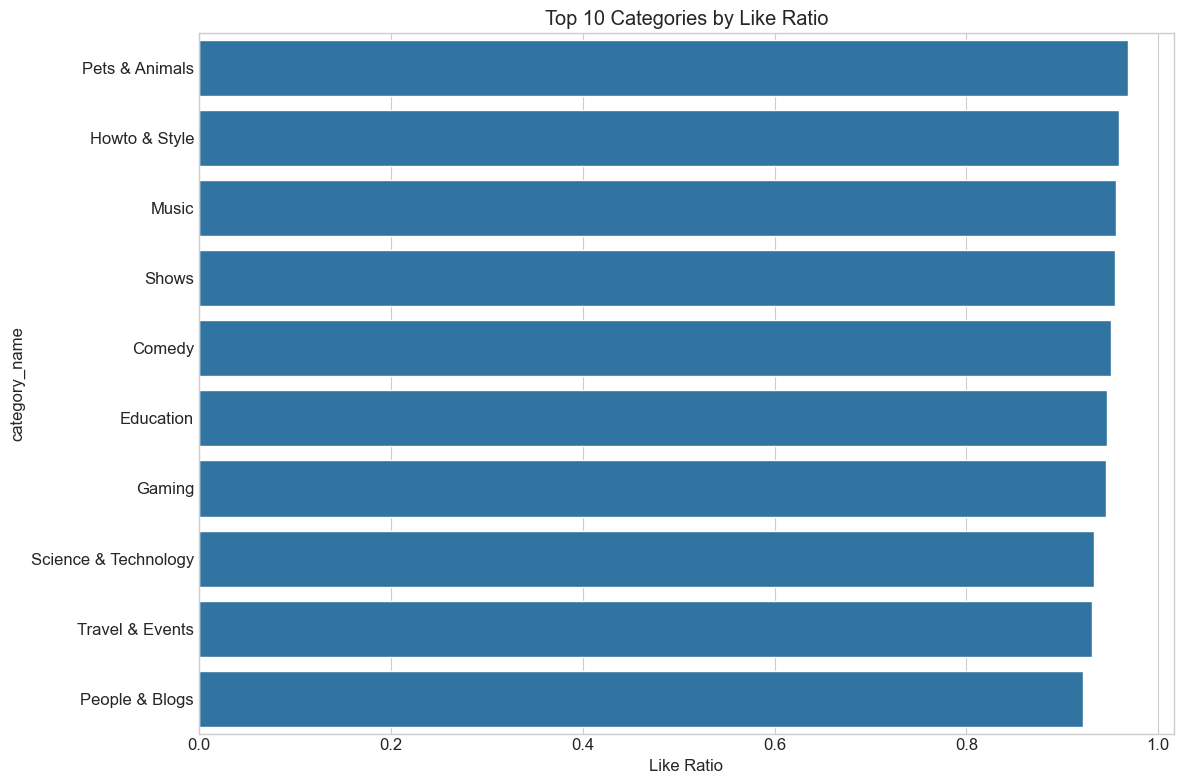

In [53]:
# 7. Category Analysis

# Analyze performance by category
category_metrics = youtube_clean_no_outliers.groupby('category_name').agg({
    'views': 'mean',
    'likes': 'mean',
    'engagement_ratio': 'mean',
    'like_ratio': 'mean',
    'video_id': 'count'
}).rename(columns={'video_id': 'count'}).sort_values('views', ascending=False)

# Display top categories by views
print("Top Categories by Average Views:")
print(category_metrics[['views', 'count']].head(10))

# Visualize category performance
plt.figure(figsize=(12, 8))
top_categories = category_metrics.sort_values('engagement_ratio', ascending=False).head(10)
sns.barplot(x='engagement_ratio', y=top_categories.index, data=top_categories)
plt.title('Top 10 Categories by Engagement Ratio')
plt.xlabel('Engagement Ratio')
plt.tight_layout()
plt.show()

# Visualize like ratio by category
plt.figure(figsize=(12, 8))
top_categories = category_metrics.sort_values('like_ratio', ascending=False).head(10)
sns.barplot(x='like_ratio', y=top_categories.index, data=top_categories)
plt.title('Top 10 Categories by Like Ratio')
plt.xlabel('Like Ratio')
plt.tight_layout()
plt.show()


In [54]:
# 1. Load Additional Country Data
import os

# Get list of all CSV files in dataset2 directory
csv_files = [f for f in os.listdir('dataset2') if f.endswith('.csv')]
print(f"Available country datasets: {csv_files}")

# Define a function to load and preprocess a country's data
def load_country_data(csv_filename):
    country_code = csv_filename.split('videos.csv')[0].upper()
    df = pd.read_csv(f'dataset2/{csv_filename}')
    
    # Add country code as a column
    df['country'] = country_code
    
    # Get category mapping
    json_file = f'dataset2/{country_code}_category_id.json'
    if os.path.exists(json_file):
        with open(json_file, 'r') as f:
            categories_data = json.load(f)
        
        # Create category map
        category_map = {}
        for item in categories_data['items']:
            category_map[item['id']] = item['snippet']['title']
        
        # Add category names
        df['category_name'] = df['category_id'].astype(str).map(category_map)
    
    return df

# Choose a subset of countries to analyze (to avoid memory issues)
selected_countries = ['USvideos.csv', 'GBvideos.csv', 'CAvideos.csv']
country_data = {}

for country_file in selected_countries:
    country_code = country_file.split('videos.csv')[0].upper()
    print(f"Loading data for {country_code}...")
    country_data[country_code] = load_country_data(country_file)
    print(f"  {country_code} shape: {country_data[country_code].shape}")

# Create a combined dataset
combined_df = pd.concat(country_data.values(), ignore_index=True)
print(f"\nCombined dataset shape: {combined_df.shape}")
print(f"Countries included: {combined_df['country'].unique()}")
combined_df.head(3)


Available country datasets: ['CAvideos.csv', 'DEvideos.csv', 'FRvideos.csv', 'GBvideos.csv', 'INvideos.csv', 'JPvideos.csv', 'KRvideos.csv', 'MXvideos.csv', 'RUvideos.csv', 'USvideos.csv']
Loading data for US...
  US shape: (40949, 18)
Loading data for GB...
  GB shape: (38916, 18)
Loading data for CA...
  CA shape: (40881, 18)

Combined dataset shape: (120746, 18)
Countries included: ['US' 'GB' 'CA']


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category_name
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US,Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,US,Comedy


In [55]:
# 2. Clean the Combined Dataset
combined_clean = combined_df.copy()

# Handle missing values
combined_clean['description'].fillna('', inplace=True)
combined_clean['tags'].fillna('', inplace=True)
combined_clean['category_name'].fillna('Unknown', inplace=True)

# Standardize text columns
combined_clean['title'] = combined_clean['title'].str.strip()
combined_clean['channel_title'] = combined_clean['channel_title'].str.strip()

# Calculate engagement metrics
combined_clean['engagement_ratio'] = 0.0
mask = combined_clean['views'] > 0
combined_clean.loc[mask, 'engagement_ratio'] = (combined_clean.loc[mask, 'likes'] + 
                                              combined_clean.loc[mask, 'dislikes']) / combined_clean.loc[mask, 'views']

combined_clean['like_ratio'] = 0.0
mask = (combined_clean['likes'] + combined_clean['dislikes']) > 0
combined_clean.loc[mask, 'like_ratio'] = combined_clean.loc[mask, 'likes'] / (
    combined_clean.loc[mask, 'likes'] + combined_clean.loc[mask, 'dislikes'])


Comparison of metrics across countries:
         video_count         views          likes     dislikes  comment_count  \
country                                                                         
CA             40881  1.147036e+06   39582.688241  2009.195445    5042.974707   
GB             38916  5.911944e+06  134519.553500  7612.559975   13088.353145   
US             40949  2.360785e+06   74266.702435  3711.400889    8446.803683   

         engagement_ratio  like_ratio  
country                                
CA               0.034736    0.925426  
GB               0.035381    0.933403  
US               0.036027    0.929239  


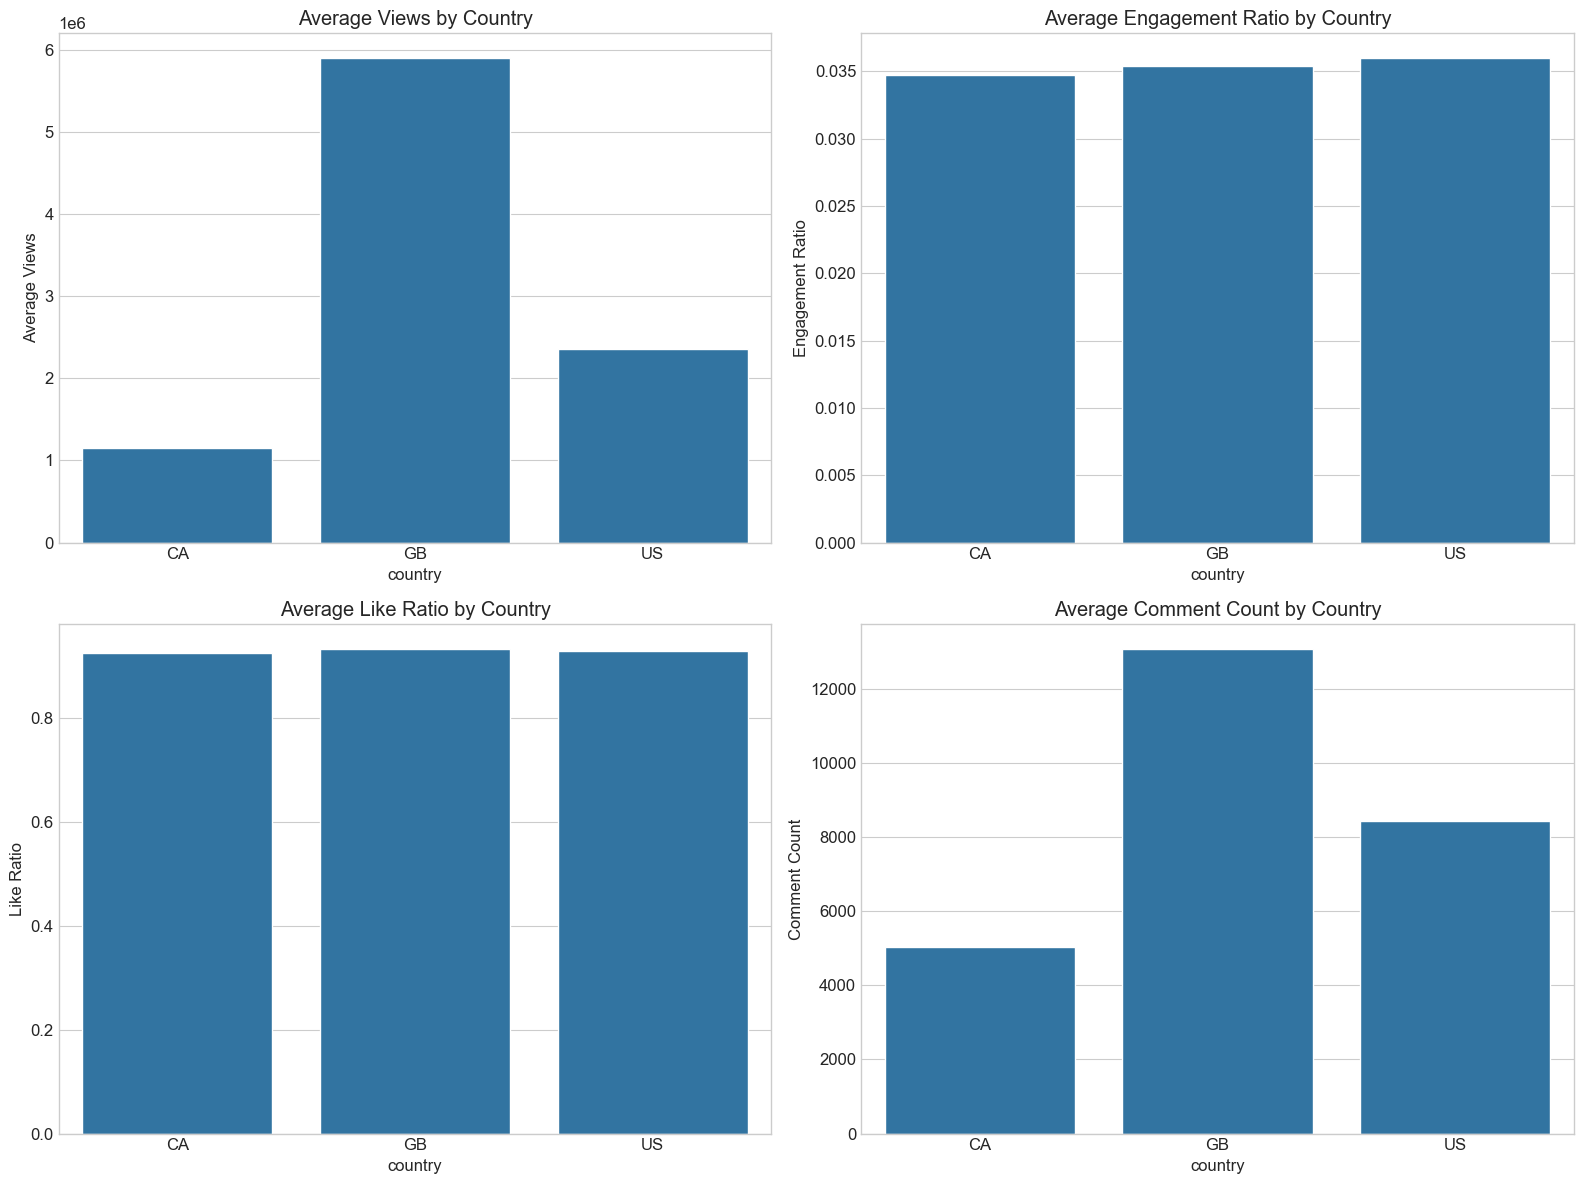

In [56]:
# 3. Cross-Country Analysis

# Compare metrics across countries
country_metrics = combined_clean.groupby('country').agg({
    'video_id': 'count',
    'views': 'mean',
    'likes': 'mean',
    'dislikes': 'mean',
    'comment_count': 'mean',
    'engagement_ratio': 'mean',
    'like_ratio': 'mean'
}).rename(columns={'video_id': 'video_count'})

print("Comparison of metrics across countries:")
print(country_metrics)

# Visualize key metrics
plt.figure(figsize=(16, 12))

# Views comparison
plt.subplot(2, 2, 1)
sns.barplot(x=country_metrics.index, y=country_metrics['views'])
plt.title('Average Views by Country')
plt.ylabel('Average Views')

# Engagement ratio comparison
plt.subplot(2, 2, 2)
sns.barplot(x=country_metrics.index, y=country_metrics['engagement_ratio'])
plt.title('Average Engagement Ratio by Country')
plt.ylabel('Engagement Ratio')

# Like ratio comparison
plt.subplot(2, 2, 3)
sns.barplot(x=country_metrics.index, y=country_metrics['like_ratio'])
plt.title('Average Like Ratio by Country')
plt.ylabel('Like Ratio')

# Comment count comparison
plt.subplot(2, 2, 4)
sns.barplot(x=country_metrics.index, y=country_metrics['comment_count'])
plt.title('Average Comment Count by Country')
plt.ylabel('Comment Count')

plt.tight_layout()
plt.show()


Top categories in each country:
                      US       GB       CA
category_name                             
Comedy            3457.0      NaN   3773.0
Entertainment     9964.0   9124.0  13451.0
Film & Animation     NaN   2577.0      NaN
Howto & Style     4146.0   1928.0      NaN
Music             6472.0  13754.0   3731.0
News & Politics      NaN      NaN   4159.0
People & Blogs    3210.0   2926.0   4105.0


<Figure size 1400x800 with 0 Axes>

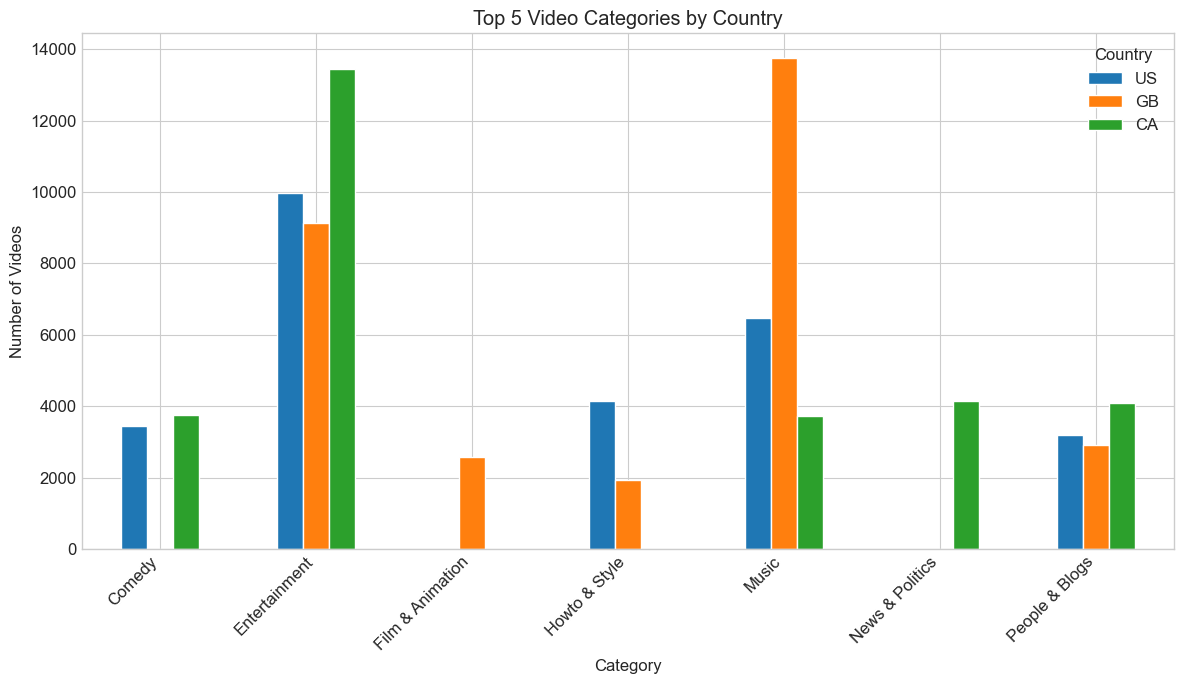

In [57]:
# 4. Category Popularity Across Countries

# Get top categories in each country
def get_top_categories(country_data, top_n=5):
    category_counts = country_data['category_name'].value_counts().head(top_n)
    return category_counts

country_top_categories = {}
for country in combined_clean['country'].unique():
    country_data = combined_clean[combined_clean['country'] == country]
    country_top_categories[country] = get_top_categories(country_data)

# Create a dataframe for visualization
top_categories_df = pd.DataFrame(country_top_categories)
print("Top categories in each country:")
print(top_categories_df)

# Visualize top categories
plt.figure(figsize=(14, 8))
top_categories_df.plot(kind='bar')
plt.title('Top 5 Video Categories by Country')
plt.ylabel('Number of Videos')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country')
plt.tight_layout()
plt.show()



Top 10 tags in US:
         Tag  US_Count
0    "funny"      4123
1   "comedy"      3573
2   "how to"      1652
3      "pop"      1627
4    "music"      1562
5     [none]      1535
6  "trailer"      1278
7     "food"      1255
8     "2018"      1251
9   "review"      1236

Top 10 tags in GB:
             Tag  GB_Count
0        "funny"      3010
1       "comedy"      2800
2        "music"      2658
3          "pop"      2254
4         [none]      2010
5          "rap"      1737
6  "music video"      1692
7     "official"      1596
8      "trailer"      1513
9      "hip hop"      1477

Top 10 tags in CA:
               Tag  CA_Count
0          "funny"      3836
1         "comedy"      2899
2           [none]      2385
3           "news"      2034
4       "politics"      1463
5   "donald trump"      1248
6          "video"      1133
7          "music"      1112
8           "2018"      1106
9  "entertainment"      1098


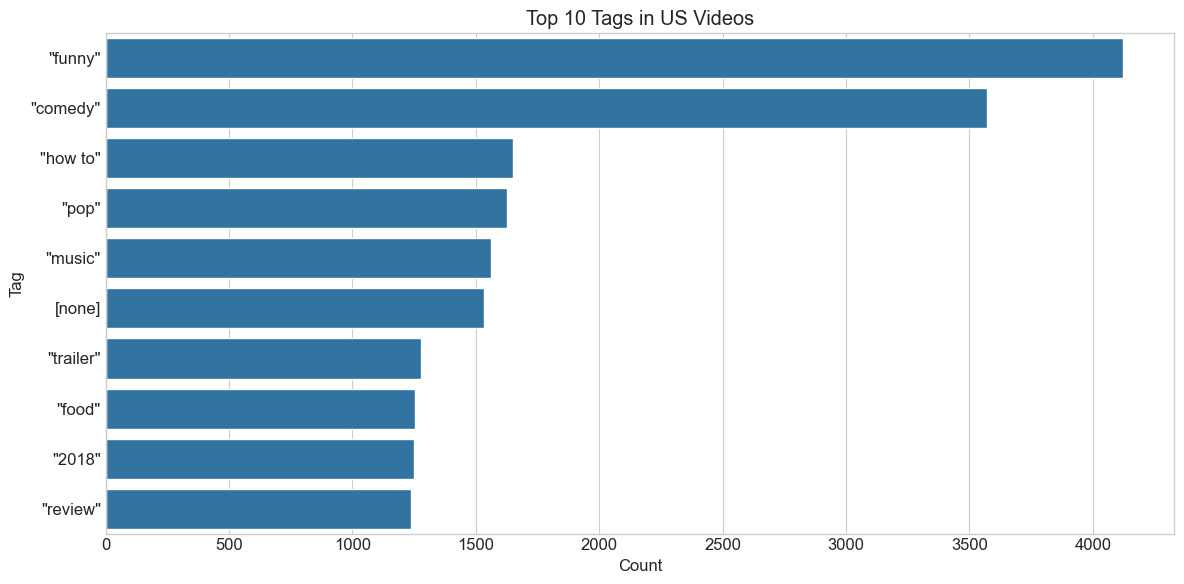

In [58]:
# 5. Common Tags Across Countries

# Process tags by country
country_tags = {}

for country in combined_clean['country'].unique():
    country_data = combined_clean[combined_clean['country'] == country]
    tags_list = country_data['tags'].fillna('')
    all_tags = []
    
    for tag_str in tags_list:
        if isinstance(tag_str, str) and tag_str:
            try:
                cleaned_tags = [tag.strip().lower() for tag in tag_str.split('|') if tag.strip()]
                all_tags.extend(cleaned_tags)
            except Exception as e:
                continue
    
    # Get most common tags
    tag_counter = Counter(all_tags)
    country_tags[country] = tag_counter

# Get top tags for each country
top_n = 10
top_country_tags = {}

for country, tag_counter in country_tags.items():
    top_country_tags[country] = pd.DataFrame(tag_counter.most_common(top_n), 
                                            columns=['Tag', f'{country}_Count'])

# Print top tags for each country
for country, tag_df in top_country_tags.items():
    print(f"\nTop {top_n} tags in {country}:")
    print(tag_df)

# Visualize top tags for one country as an example
plt.figure(figsize=(12, 6))
us_tags = top_country_tags['US']
sns.barplot(x=us_tags['US_Count'], y=us_tags['Tag'])
plt.title(f'Top {top_n} Tags in US Videos')
plt.xlabel('Count')
plt.tight_layout()
plt.show()
